In [3]:
import numpy as np
import matplotlib.pyplot as plt

#### Declare Variables 

In [84]:
n_states = 20 #number of states in the GMM
poly_deg = 2 #Degree of the polynomial
n_out = 2 #number of motion variables
n_data = 200 #length of trajectory
n_samples = 5 #number of demonstrations
t_in = np.linspace(0,1,n_data) #input data for LWR

#### Load Data 

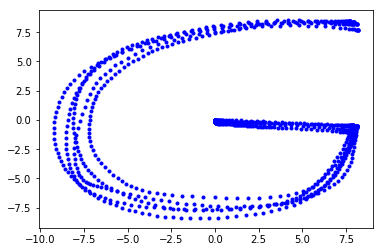

In [154]:
ROOT = 'python_data/2Dletters/'
data = np.load(ROOT + 'G.npy')[1:n_samples+1]

#construct the output Y by concatenating all demonstrations
data = data.transpose([0,2,1])
Y = np.concatenate(data,axis=0)

plt.plot(Y[:,0], Y[:,1],'.b')

#### Set the basis functions 

In [129]:
t_sep = np.linspace(-0.3,1.3,n_states+1)
mus = np.zeros(n_states)
for i in range(n_states):
    mus[i] = 0.5*(t_sep[i]+t_sep[i+1])

sigmas = np.array([2e-3]*n_states)

In [130]:
from scipy.stats import norm as normal_dist

#### Compute the activation weigths

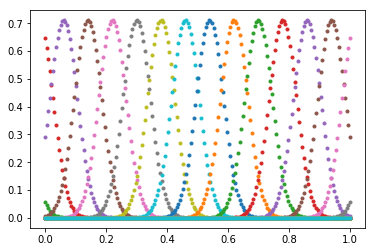

In [131]:
H = np.zeros((n_states, n_data))
for i in range(n_states):
    H[i] = normal_dist(loc = mus[i], scale = np.sqrt(sigmas[i])).pdf(t_in)
H /= np.sum(H,axis=0) #normalizing the weights

for i in range(n_states):
    plt.plot(t_in, H[i],'.')

Hn = np.tile(H,(1,n_samples)) #repeat Hn for n samples

#### Compute LWR 

In [132]:
#construct the polynomial input of degree=poly_deg

In [133]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=poly_deg)
Xr = poly.fit_transform(t_in[:,None])
X = np.tile(Xr,(n_samples,1))

In [134]:
from numpy import dot
from numpy.linalg import inv

In [135]:
As = []
for i in range(n_states):
    W = np.diag(Hn[i])
    A = dot(inv(dot(X.T,dot(W,X))+np.eye(poly_deg+1)*1e-5),dot(X.T, dot(W,Y)))
    As.append(A)

In [136]:
%matplotlib inline

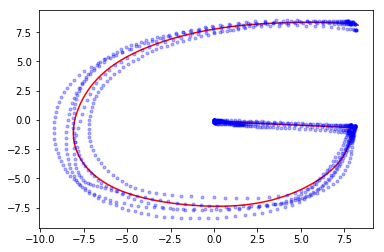

In [153]:
Y_preds = []
for i in range(n_states):
    Y_pred = np.multiply(H[i][:,None], dot(Xr,As[i]))
    Y_preds.append(Y_pred)
    
Y_preds = np.array(Y_preds)
Y_preds = np.sum(Y_preds, axis=0)

plt.plot(Y_preds[:,0], Y_preds[:,1],'-r', alpha=1)
plt.plot(Y[:,0], Y[:,1],'.b', alpha=0.3)

In [138]:
%matplotlib inline

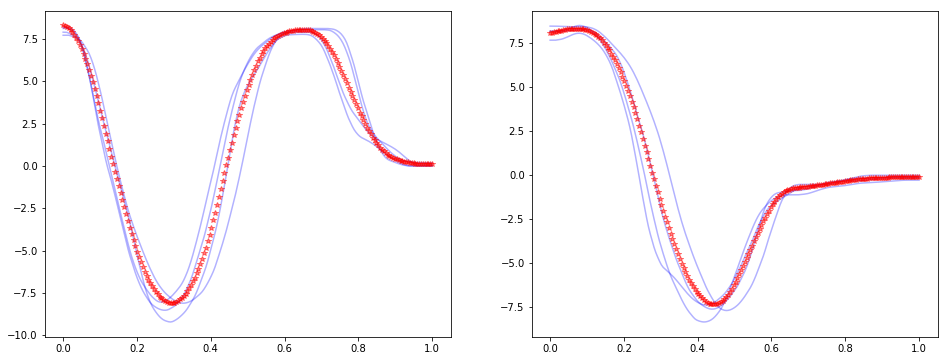

In [149]:
plt.figure(figsize=(16, 6))
for i in range(1,n_samples):
    plt.subplot(1,2,1)
    plt.plot(t_in, Y[i*n_data:(i+1)*n_data,0],'-b', alpha=0.3)
    plt.subplot(1,2,2)
    plt.plot(t_in, Y[i*n_data:(i+1)*n_data,1],'-b',alpha=0.3)

plt.subplot(1,2,1)    
plt.plot(t_in, Y_preds[:,0], '*r', alpha=0.5)
plt.subplot(1,2,2)
plt.plot(t_in, Y_preds[:,1], '*r', alpha=0.5)
